# TiTiler research. 
This notebooks contains exploratory code to assess the use of [TiTiler](https://developmentseed.org/titiler/) as the tiler to use for the contextual layers of the platform, working on on Cloud-Optimised GeoTIFFs (COGs) format.  

This involves:
1) Preparing the data. 
2) The process of creating and validating the COG.  
3) Uploading the COG to a cloud plaatform (Google bucket). 
4) Using TiTiler's API to generate tiled raster.  


In [29]:
import numpy as np
import pandas as pd
import rasterio as rio
import rasterio.plot
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

## 1. Prepare data

In [18]:
bws = '../../datasets/raw/raster_aqueduct3_bws.tif'


In [20]:
!gdalinfo $bws -stats

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/raster_aqueduct3_bws.tif
Size is 4320, 2160
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-180.000000000000000,89.999999999989768)
Pixel Size = (0.083333333333329,-0.083333333333329)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-180.0000000,  90.0000000) (180d 0' 0.00"W, 90d 0' 0.00"N)
Lower Left  (-180.0000000, -90.0000000) (180d 0' 0.00"W, 90d 0' 0.00"S)
Upp

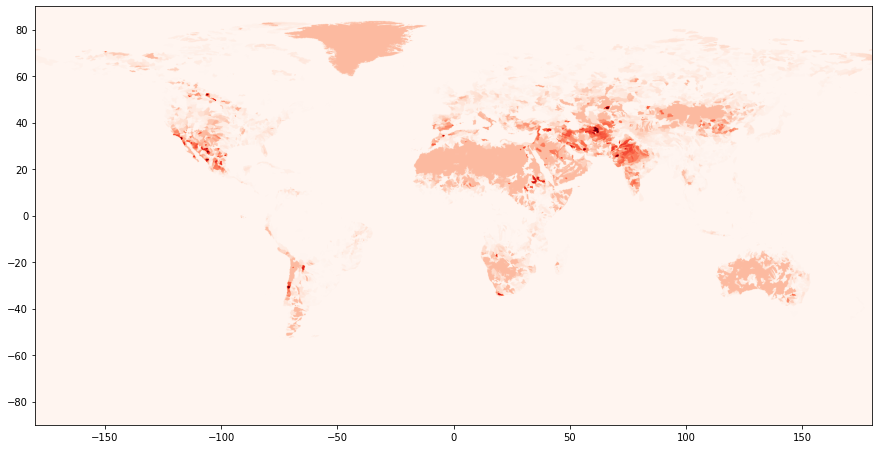

In [32]:
with rio.open(bws) as src:

    dat = src.read(1)
    dat = np.where(dat < 0, 0, dat)
    dat = np.where(dat > 4, 4, dat)
    fig, ax = plt.subplots(figsize=[15,10])
    rio.plot.show(dat, ax=ax, cmap='Reds', transform=src.transform)


## 2. Transform Tiff to COG

In [34]:
cog_tif = '../../datasets/raw/bwd_cog.tif'
!rio cogeo create $bws $cog_tif

Reading input: /home/jovyan/work/datasets/raw/raster_aqueduct3_bws.tif
  [####################################]  100%
Adding overviews...
Updating dataset tags...
Writing output to: /home/jovyan/work/datasets/raw/bwd_cog.tif


### Validate COG

In [35]:
!rio cogeo validate $cog_tif

/home/jovyan/work/datasets/raw/bwd_cog.tif is a valid cloud optimized GeoTIFF


In [36]:
!gdalinfo $cog_tif

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/bwd_cog.tif
Size is 4320, 2160
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-180.000000000000000,89.999999999989768)
Pixel Size = (0.083333333333329,-0.083333333333329)
Metadata:
  AREA_OR_POINT=Area
  OVR_RESAMPLING_ALG=NEAREST
Image Structure Metadata:
  COMPRESSION=DEFLATE
  INTERLEAVE=BAND
  LAYOUT=COG
Corner Coordinates:
Upper Left  (-180.0000000,  90.0000000) (180d 0' 0.00"W, 90d 0' 0.00"N)
Lower Left  (-180.000000

## 3. Upload COG to AWS S3 bucket  

The bucket for landgriffon-data [is here](https://landgriffon-raw-data.s3.eu-west-3.amazonaws.com/bwd_cog.tif).  
Data uploaded by Back-End in this case

## 4. Use TiTiler API.  

The idea is to retrieve the COG directly from the S3 bucket, and pass it to the TiTiler's API to get the tiled layer.



In [1]:
import os
import json
import urllib.parse
from io import BytesIO
from functools import partial
from concurrent import futures

import httpx
import boto3
from boto3.session import Session as boto3_session

from rasterio.plot import reshape_as_image
from rasterio.features import bounds as featureBounds

from tqdm.notebook import tqdm

from folium import Map, TileLayer

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
titiler_endpoint = "https://titiler.xyz"
url_cog = 'https://landgriffon-raw-data.s3.eu-west-3.amazonaws.com/bwd_cog.tif'

In [6]:
env_path = ".env"
with open(env_path) as f:
    env = {}
    for line in f:
        env_key, _val = line.split("=", 1)
        env_value = _val.split("\n")[0]
        env[env_key] = env_value
        
#list(env.keys())

In [7]:
os.environ["AWS_ACCESS_KEY_ID"] = env['AWS_ACCESS_KEY_ID']
os.environ["AWS_SECRET_ACCESS_KEY"] = env['AWS_SECRET_ACCESS_KEY']



### Check files on the S3 Bucket

In [11]:
session = boto3_session(region_name="eu-west-3")
client = session.client("s3")

bucket = "landgriffon-raw-data"


def list_objects(bucket):
    """AWS s3 list objects."""

    paginator = client.get_paginator('list_objects_v2')

    files = []
    for subset in paginator.paginate(Bucket=bucket):
        files.extend(subset.get("Contents", []))

    return [r["Key"] for r in files]

files = list_objects(bucket)
print(f"Found : {len(files)}")

Found : 1


In [12]:
print(files)

['bwd_cog.tif']


### Check COG info using TiTiler's API

URL is passed either in HTTPS format (object `url_cog`) or S3 format (using a custom function) to the API endpoint.  

In [43]:
r = httpx.get(
    f"{titiler_endpoint}/cog/info",
    params = {
        "url": url_cog,
    }
).json()

bounds = r["bounds"]
print(r)

{'bounds': [-180.0, -90.00000000000088, 179.9999999999813, 89.99999999998977], 'minzoom': 0, 'maxzoom': 4, 'band_metadata': [['1', {}]], 'band_descriptions': [['1', '']], 'dtype': 'float32', 'nodata_type': 'None', 'colorinterp': ['gray'], 'driver': 'GTiff', 'height': 2160, 'overviews': [2, 4, 8], 'count': 1, 'width': 4320}


In [16]:
def _url(src_path):
    return f"s3://landgriffon-raw-data/{src_path}"

r = httpx.get(
    f"{titiler_endpoint}/cog/statistics",
    params = {
        "url": _url(files[0])
    }
).json()

print(json.dumps(r, indent=4))

{
    "1": {
        "min": -4055.908203125,
        "max": 147.76255798339844,
        "mean": 0.05271616578102112,
        "count": 524288.0,
        "sum": 27638.453125,
        "std": 11.226435617631868,
        "median": 0.0,
        "majority": 0.0,
        "minority": -2.2075929641723633,
        "unique": 12129.0,
        "histogram": [
            [
                4.0,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0,
                524284.0
            ],
            [
                -4055.908203125,
                -3635.541015625,
                -3215.174072265625,
                -2794.806884765625,
                -2374.43994140625,
                -1954.0728759765625,
                -1533.7056884765625,
                -1113.338623046875,
                -692.9716186523438,
                -272.6045227050781,
                147.76255798339844
      

### Validate COG

In [39]:
def _url(src_path):
    return f"s3://landgriffon-raw-data/{src_path}"

r = httpx.get(
    f"{titiler_endpoint}/cog/validate",
    params = {
        "url": _url(files[0])
    }
).json()

print(json.dumps(r, indent=4))

{
    "Path": "s3://landgriffon-raw-data/bwd_cog.tif",
    "Driver": "GTiff",
    "COG": true,
    "Compression": "DEFLATE",
    "ColorSpace": null,
    "COG_errors": null,
    "COG_warnings": null,
    "Profile": {
        "Bands": 1,
        "Width": 4320,
        "Height": 2160,
        "Tiled": true,
        "Dtype": "float32",
        "Interleave": "BAND",
        "AlphaBand": false,
        "InternalMask": false,
        "Nodata": null,
        "ColorInterp": [
            "gray"
        ],
        "ColorMap": false,
        "Scales": [
            1.0
        ],
        "Offsets": [
            0.0
        ]
    },
    "GEO": {
        "CRS": "EPSG:4326",
        "BoundingBox": [
            -180.0,
            -90.00000000000088,
            179.9999999999813,
            89.99999999998977
        ],
        "Origin": [
            -180.0,
            89.99999999998977
        ],
        "Resolution": [
            0.083333333333329,
            -0.083333333333329
        ],
  

### Generate and visualize tiles

In [45]:

r = httpx.get(
    f"{titiler_endpoint}/cog/tilejson.json",
    params = {
        "url": url_cog,
        "rescale": "0.1,100",
        "colormap_name": "viridis",
    }
).json()
r

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://titiler.xyz/cog/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?url=https%3A%2F%2Flandgriffon-raw-data.s3.eu-west-3.amazonaws.com%2Fbwd_cog.tif&rescale=0.1%2C100&colormap_name=viridis'],
 'minzoom': 0,
 'maxzoom': 4,
 'bounds': [-180.0, -90.00000000000088, 179.9999999999813, 89.99999999998977],
 'center': [-9.350742402602918e-12, -5.5564441936439835e-12, 0]}

In [47]:
m = Map(
    location=((bounds[1] + bounds[3]) / 2,(bounds[0] + bounds[2]) / 2),
    zoom_start=3
)

aod_layer = TileLayer(
    tiles=r["tiles"][0],
    opacity=1,
    attr="DigitalGlobe OpenData"
)
aod_layer.add_to(m)
m

Note: Map is in raw scale (not like in the plot at the beginning of the notebook) and therefore very high and low values reduce the contrast of informative value, but it is there nonetheless.